In [ ]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
import scipy.misc
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import datasets, layers, models, optimizers, regularizers
from keras.preprocessing.image import img_to_array, array_to_img, load_img
from tensorflow.keras.applications.resnet50 import ResNet50

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y
  

In [ ]:
def load_dataset():
    train_dataset = h5py.File('/content/drive/My Drive/Datasets/UCMerced_LandUse/Train_UCMerced_LandUse.h5', 'r')
    train_set_x_orig = np.array(train_dataset["X_train_dataset"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["Y_train_dataset"][:]) # your train set labels

    test_dataset = h5py.File('/content/drive/My Drive/Datasets/UCMerced_LandUse/Test_UCMerced_LandUse.h5', 'r')
    test_set_x_orig = np.array(test_dataset["X_test_dataset"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["Y_test_dataset"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [ ]:
# Loading the data (Dataset)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

y = 4


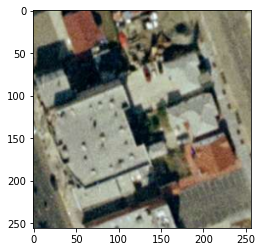

In [ ]:
index = 25
plt.imshow(Image.fromarray(X_train_orig[index].astype(np.uint8)))
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [ ]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig.T, 21)
Y_test = convert_to_one_hot(Y_test_orig.T, 21)

#print ("number of training examples = " + str(X_train.shape[0]))
#print ("number of test examples = " + str(X_test.shape[0]))
#print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
#print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

Y_train shape: (1680, 21)
Y_test shape: (420, 21)


In [ ]:
Resnet_Out = h5py.File('/content/drive/My Drive/Datasets/UCMerced_LandUse/Convout/TLB1000/Resnet_Out.h5', 'r')
Txtrain = np.array(Resnet_Out["train_OutResnet"][:])
Txtest = np.array(Resnet_Out["test_OutResnet"][:])
Resnet_Out.close()

print("Txtrain Shape:", Txtrain.shape)
print("Txtest Shape:", Txtest.shape)

Txtrain Shape: (1680, 2048)
Txtest Shape: (420, 2048)


In [ ]:
model = models.Sequential()
model.add(layers.Input(shape = (2048)))
model.add(layers.Dense(21, activation='softmax'))
print(model.summary())

optimizers.Adam(learning_rate=0.1, name="Adam")
model.compile(optimizer='Adam',loss = 'categorical_crossentropy', metrics=['accuracy'])

Vhistory = model.fit(Txtrain, Y_train, epochs=200, batch_size=64, validation_split = 0.25)

train_loss, train_acc = model.evaluate(Txtrain,  Y_train, verbose=1)
print("Loss: ", train_loss, " Train Accuracy: ", train_acc)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 21)                43029     
Total params: 43,029
Trainable params: 43,029
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
20/20 [==============================] - 0s 12ms/step - loss: 1.7264 - accuracy: 0.4944 - val_loss: 0.8963 - val_accuracy: 0.7214
Epoch 2/200
20/20 [==============================] - 0s 4ms/step - loss: 0.3648 - accuracy: 0.9151 - val_loss: 0.6313 - val_accuracy: 0.7833
Epoch 3/200
20/20 [==============================] - 0s 4ms/step - loss: 0.1798 - accuracy: 0.9659 - val_loss: 0.5710 - val_accuracy: 0.8190
Epoch 4/200
20/20 [==============================] - 0s 4ms/step - loss: 0.1188 - accuracy: 0.9857 - val_loss: 0.5218 - val_accuracy: 0.8333
Epoch 5/200
20/20 [==============================] - 0s 4ms/step - loss: 0.0

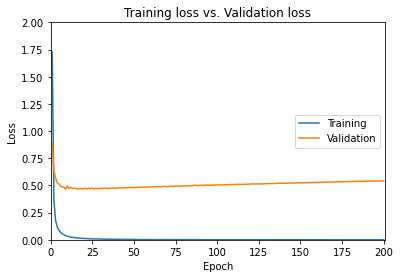

In [ ]:
epochs = len(Vhistory.history['loss'])
max_loss = max(max(Vhistory.history['loss']), max(Vhistory.history['val_loss']))
plt.axis([0, epochs+1, 0, round(max_loss * 2.0) / 2 + 0.5])
x = np.arange(1, epochs+1)
plt.plot(x, Vhistory.history['loss'])
plt.plot(x, Vhistory.history['val_loss'])
plt.title('Training loss vs. Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='right')
plt.show()

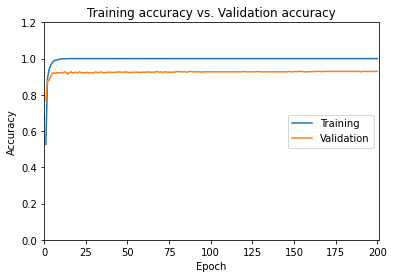

In [ ]:
epochs = len(Vhistory.history['accuracy'])
plt.axis([0, epochs+1, 0, 1.2])
x = np.arange(1, epochs+1)
plt.plot(x, Vhistory.history['accuracy'])
plt.plot(x, Vhistory.history['val_accuracy'])
plt.title('Training accuracy vs. Validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='right')
plt.show()

In [ ]:
epochs = np.argmin(Vhistory.history['val_loss']) + 1

history = model.fit(Txtrain, Y_train, epochs=epochs, verbose=1, batch_size=64)

train_loss, train_acc = model.evaluate(Txtrain,  Y_train, verbose=1)
print("Loss: ", train_loss, " Train Accuracy: ", train_acc)

test_loss, test_acc = model.evaluate(Txtest,  Y_test, verbose=1)
print("Loss: ", test_loss, " Test Accuracy: ", test_acc)

Epoch 1/30
30/30 [==============================] - 0s 2ms/step - loss: 1.6315e-04 - accuracy: 1.0000
Epoch 2/30
30/30 [==============================] - 0s 2ms/step - loss: 1.6153e-04 - accuracy: 1.0000
Epoch 3/30
30/30 [==============================] - 0s 2ms/step - loss: 1.5833e-04 - accuracy: 1.0000
Epoch 4/30
30/30 [==============================] - 0s 2ms/step - loss: 1.5539e-04 - accuracy: 1.0000
Epoch 5/30
30/30 [==============================] - 0s 2ms/step - loss: 1.5270e-04 - accuracy: 1.0000
Epoch 6/30
30/30 [==============================] - 0s 2ms/step - loss: 1.5028e-04 - accuracy: 1.0000
Epoch 7/30
30/30 [==============================] - 0s 2ms/step - loss: 1.4758e-04 - accuracy: 1.0000
Epoch 8/30
30/30 [==============================] - 0s 2ms/step - loss: 1.4544e-04 - accuracy: 1.0000
Epoch 9/30
30/30 [==============================] - 0s 2ms/step - loss: 1.4367e-04 - accuracy: 1.0000
Epoch 10/30
30/30 [==============================] - 0s 2ms/step - loss: 1.4044e-0

In [ ]:
print(Txtrain[18])   

[0.00000000e+00 0.00000000e+00 1.80010404e-03 ... 1.96212125e+00
 0.00000000e+00 0.00000000e+00]


In [ ]:
import pandas as pd

array1 = np.zeros((200,2))
array1[:,0] = Vhistory.history['loss']
array1[:,1] = Vhistory.history['val_loss']

array2 = np.zeros((200,2))
array2[:,0] = Vhistory.history['accuracy']
array2[:,1] = Vhistory.history['val_accuracy']

df1 = pd.DataFrame(array1)
df1.to_excel("/content/drive/My Drive/ResML.xlsx", sheet_name='Merced Loss')

df2 = pd.DataFrame(array2)
df2.to_excel("/content/drive/My Drive/ResMA.xlsx", sheet_name='Merced accuracy')